In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## General definitions

In [2]:
hubble = 0.697
BoxSize = 64.0

In [3]:
def load_rockstar_data(rockstar_name, boxsize=64.0):
    dtype=[
        ('ID' ,'i8'),('DescID' ,'i8'),('Mvir','f8'),('Vmax','f8'),('Vrms','f8'),('Rvir','f8'),('Rs','f8'),( 'Np','i8'),
        ( 'X','f8'),( 'Y','f8'),( 'Z','f8'),( 'VX','f8'),( 'VY','f8'),( 'VZ','f8'),
        ( 'JX','f8'),( 'JY','f8'),( 'JZ','f8'),( 'Spin','f8'),( 'rs_klypin' ,'f8'),('Mvir_all' ,'f8'),('M200b','f8'),
        ( 'M200c','f8'),( 'M500c','f8'),( 'M2500c' ,'f8'),('Xoff','f8'),( 'Voff','f8'),( 'spin_bullock','f8'),
        ( 'b_to_a','f8'),( 'c_to_a','f8'),( 'A[x]' ,'f8'),('A[y]','f8'),('A[z]','f8'),
        ( 'b_to_a(500c)' ,'f8'),('c_to_a(500c)' ,'f8'),('A[x](500c)','f8'),( 'A[y](500c)' ,'f8'),
        ('A[z](500c)' ,'f8'),('T_U','f8'),( 'M_pe_Behroozi','f8'),( 'M_pe_Diemer','f8'),('Halfmass_Radius','f8'), 
        ('PID', 'i8')]
    snap_data = np.loadtxt(rockstar_name, dtype=dtype)    
   
    return snap_data

In [4]:
gr_full_data = load_rockstar_data('../data/halos/GR/out_0.list')
fr_full_data = load_rockstar_data('../data/halos/FR6/out_0.list')

In [5]:
ii = (gr_full_data['Mvir']/hubble > 1E11) & (gr_full_data['PID']==-1)
gr_data = gr_full_data[ii]
ii = (fr_full_data['Mvir']/hubble > 1E11) & (fr_full_data['PID']==-1)
fr_data = fr_full_data[ii]

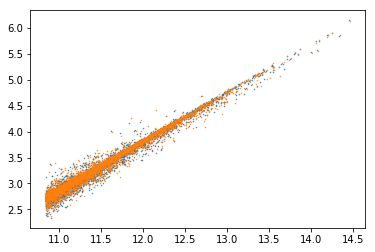

In [6]:
plt.scatter(np.log10(gr_data['Mvir']), np.log10(gr_data['Np']), s=0.2)
plt.scatter(np.log10(fr_data['Mvir']), np.log10(fr_data['Np']), s=0.2)

In [7]:
def find_LG_pairs(in_data):
    #pad boxes to mimic periodic boundary conditions
    new_data = in_data.copy()
    n = len(new_data)
    pos = np.ones([n,3])
    vel = np.ones([n,3])
    for i,j in zip([0,1,2], ['X','Y','Z']):
        pos[:,i] = new_data[j].copy()
        vel[:,i] = new_data['V'+j].copy()
    vmax = new_data['Vmax'].copy()
    mvir = new_data['Mvir'].copy()
    haloid = np.arange(n)

    pad_pos = pos.copy()
    pad_vel = vel.copy()
    pad_vmax = vmax.copy()
    pad_mvir = mvir.copy()
    pad_haloid = haloid.copy()

    for i in (0,1,-1):
        for j in (0,1,-1):
            for k in (0,1,-1):
                new_pos = pos.copy()
                if(i):
                    new_pos[:,0] = new_pos[:,0] + i*BoxSize
                if(j):
                    new_pos[:,1] = new_pos[:,1] + j*BoxSize
                if(k):
                    new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
                if((i!=0) | (j!=0) | (k!=0)):
                    pad_pos = np.append(pad_pos, new_pos, axis=0)
                    pad_vel = np.append(pad_vel, vel, axis=0)
                    pad_vmax = np.append(pad_vmax, vmax)
                    pad_mvir = np.append(pad_mvir, mvir)
                    pad_haloid = np.append(pad_haloid, np.arange(n))

    

    #find neighbors
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(pad_pos)
    dist, ind = nbrs.kneighbors(pad_pos)
    print(pad_pos.shape)
    print(dist.shape)
    
    neighbor_index = ind[:,1]
    neighbor_list = ind[:,2:]
    print(np.shape(neighbor_list))

    #define pairs
    n_pairs = 0

    halo_A_id = np.empty((0), dtype=int)
    halo_B_id = np.empty((0), dtype=int)
    for i in range(n):
        j = neighbor_index[i] % n # nearest neighbor of i
        l = neighbor_index[neighbor_index[i]]% n # nearest neighbor of j
    
        other_j = neighbor_list[i,:] % n # all neightbors of i.
        other_l = neighbor_list[neighbor_index[i],:] % n # all neightbors of i-th's neighbors
        if(i==l):# reciprocity principle
            virial_radius_i = fr_data['Rvir'][i]
            virial_radius_l = fr_data['Rvir'][l]
            if(dist[i,1]<(virial_radius_i + virial_radius_l)): # Check that the halos are not merging
                if((not (j in halo_A_id)) & (not (j in halo_B_id))): # don't add pairs that are already in the list
                    vmax_i = pad_vmax[i]
                    vmax_j = pad_vmax[j]
                    vmax_limit = min([vmax_i, vmax_j])
                    #dist_limit = max(3.0*hubble, 4.0*dist[i,1])
                    dist_limit = 3.0*hubble
                    massive_close_to_i = any((dist[i,2:]<dist_limit) & (pad_vmax[other_j]>=vmax_limit))
                    massive_close_to_j = any((dist[j,2:]<dist_limit) & (pad_vmax[other_l]>=vmax_limit))
                    if((not massive_close_to_i) & (not massive_close_to_j)): 
                        n_pairs = n_pairs + 1
                        halo_A_id = np.append(halo_A_id, int(i))
                        halo_B_id = np.append(halo_B_id, int(j))
    return halo_A_id, halo_B_id, \
    pad_vmax[halo_A_id], pad_vmax[neighbor_index[halo_A_id]],\
    pad_mvir[halo_A_id], pad_mvir[neighbor_index[halo_A_id]],\
    pad_pos[halo_A_id,:], pad_pos[neighbor_index[halo_A_id], :],\
        pad_vel[halo_A_id,:], pad_vel[neighbor_index[halo_A_id], :]

## Build the sample of Isolated Pairs

In [8]:
halo_A_GR, halo_B_GR, vmax_A_GR, vmax_B_GR, mvir_A_GR, mvir_B_GR, pos_A_GR, pos_B_GR, vel_A_GR, vel_B_GR = find_LG_pairs(gr_data)
halo_A_FR, halo_B_FR, vmax_A_FR, vmax_B_FR, mvir_A_FR, mvir_B_FR, pos_A_FR, pos_B_FR, vel_A_FR, vel_B_FR = find_LG_pairs(fr_data)

(278127, 3)
(278127, 20)
(278127, 18)
(284877, 3)
(284877, 20)
(284877, 18)


In [9]:
# Number of isolated pairs
print('FR', len(halo_A_FR))
print('GR', len(halo_A_GR))

FR 536
GR 526


## Compute kinematic conditions for the isolated pairs

In [10]:
relative_pos_GR = pos_B_GR - pos_A_GR
relative_vel_GR = vel_B_GR - vel_A_GR
norm_relative_vel_GR = np.sqrt((relative_vel_GR**2).sum(1))
norm_relative_pos_GR = np.sqrt((relative_pos_GR**2).sum(1))

#radial velocity includes Hubble flow
radial_vel_GR = ((relative_vel_GR[:,0] + relative_pos_GR[:,1]*100.0)*relative_pos_GR[:,0] +
            (relative_vel_GR[:,1] + relative_pos_GR[:,1]*100.0) *relative_pos_GR[:,1] + 
            (relative_vel_GR[:,2]+ relative_pos_GR[:,2]*100.0)*relative_pos_GR[:,2])/norm_relative_pos_GR

tangential_vel_GR = np.sqrt((relative_vel_GR[:,0] - relative_vel_GR[:,0]*relative_pos_GR[:,0])**2 +
                            (relative_vel_GR[:,1] - relative_vel_GR[:,1]*relative_pos_GR[:,1])**2 +
                            (relative_vel_GR[:,2] - relative_vel_GR[:,2]*relative_pos_GR[:,2])**2)

relative_pos_FR = pos_A_FR - pos_B_FR
relative_vel_FR = vel_A_FR - vel_B_FR
norm_relative_vel_FR = np.sqrt((relative_vel_FR**2).sum(1))
norm_relative_pos_FR = np.sqrt((relative_pos_FR**2).sum(1))

radial_vel_FR = ((relative_vel_FR[:,0] + relative_pos_FR[:,1]*100.0)*relative_pos_FR[:,0] +
            (relative_vel_FR[:,1] + relative_pos_FR[:,1]*100.0) *relative_pos_FR[:,1] + 
            (relative_vel_FR[:,2]+ relative_pos_FR[:,2]*100.0)*relative_pos_FR[:,2])/norm_relative_pos_FR

tangential_vel_FR = np.sqrt((relative_vel_FR[:,0] - relative_vel_FR[:,0]*relative_pos_FR[:,0])**2 +
                            (relative_vel_FR[:,1] - relative_vel_FR[:,1]*relative_pos_FR[:,1])**2 +
                            (relative_vel_FR[:,2] - relative_vel_FR[:,2]*relative_pos_FR[:,2])**2)

## Scatter plots for the kinematic conditions of isolated pairs

43.9169520051 54.1113693277


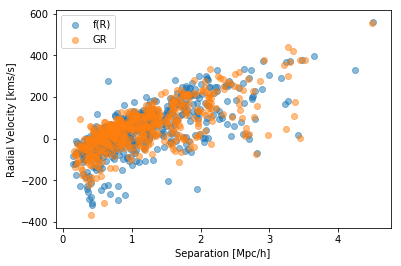

In [11]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print(radial_vel_FR.mean(), radial_vel_GR.mean())

mean negative radial velocity FR -73.9854938187
mean negative radial velocity GR -62.886860732


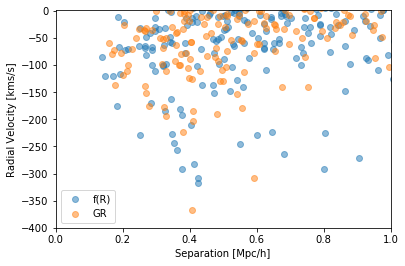

In [12]:
plt.scatter(norm_relative_pos_FR, radial_vel_FR, alpha=0.5, label="f(R)")
plt.scatter(norm_relative_pos_GR, radial_vel_GR, alpha=0.5, label="GR")
plt.xlim([0,1.0])
plt.ylim([-400.0,1.0])
plt.xlabel("Separation [Mpc/h]")
plt.ylabel("Radial Velocity [kms/s]")
plt.legend()
print("mean negative radial velocity FR",radial_vel_FR[radial_vel_FR<0]. mean())
print("mean negative radial velocity GR", radial_vel_GR[radial_vel_GR<0].mean())

43.9169520051 54.1113693277


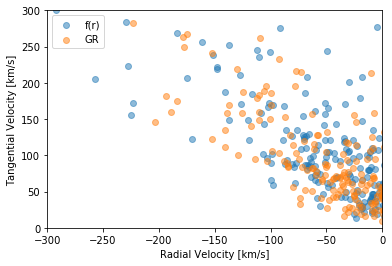

In [13]:
plt.scatter(radial_vel_FR, tangential_vel_FR, alpha=0.5, label='f(r)')
plt.scatter(radial_vel_GR, tangential_vel_GR, alpha=0.5, label='GR')
plt.xlim([-300.0,0.0])
plt.ylim([0,300])
plt.xlabel("Radial Velocity [km/s]")
plt.ylabel("Tangential Velocity [km/s]")
plt.legend()
print(radial_vel_FR.mean(), radial_vel_GR.mean())

## Distributions for the Isolated Pair sample

Ks_2sampResult(statistic=0.02494892457862774, pvalue=0.99607228246358848)

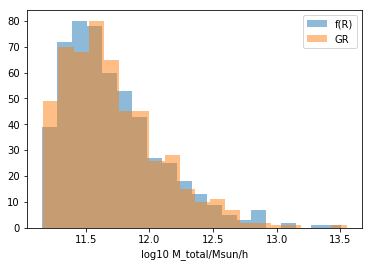

In [14]:
a = plt.hist(np.log10(mvir_A_FR + mvir_B_FR), bins=20, alpha=0.5, label='f(R)')
a = plt.hist(np.log10(mvir_A_GR + mvir_B_GR), bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("log10 M_total/Msun/h")
scipy.stats.ks_2samp(np.log10(mvir_A_FR + mvir_B_FR), np.log10(mvir_A_GR + mvir_B_GR))

Ks_2sampResult(statistic=0.02904914590545371, pvalue=0.97678926128645094)

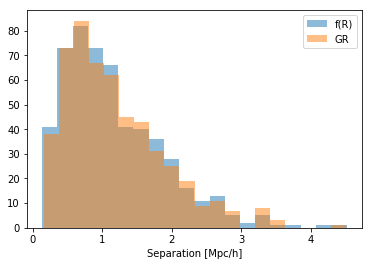

In [15]:
a = plt.hist(norm_relative_pos_FR, bins=20, alpha=0.5, label='f(R)')
a = plt.hist(norm_relative_pos_GR, bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Separation [Mpc/h]")
scipy.stats.ks_2samp(norm_relative_pos_FR,norm_relative_pos_GR)

Ks_2sampResult(statistic=0.12426933772203619, pvalue=0.00048354976329215718)

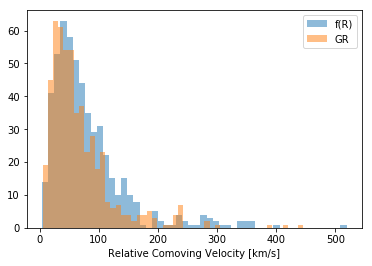

In [16]:
a = plt.hist(norm_relative_vel_FR, bins=50, alpha=0.5, label='f(R)')
a = plt.hist(norm_relative_vel_GR, bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Relative Comoving Velocity [km/s]")
scipy.stats.ks_2samp(norm_relative_vel_FR,norm_relative_vel_GR)

Ks_2sampResult(statistic=0.067625276658532407, pvalue=0.16973228222572145)

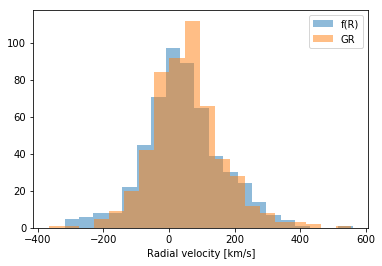

In [17]:
a = plt.hist(radial_vel_FR, bins=20, alpha=0.5, label='f(R)')
a = plt.hist(radial_vel_GR, bins=20, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Radial velocity [km/s]")
scipy.stats.ks_2samp(radial_vel_FR,radial_vel_GR)

[  51.47657485   77.40764276  108.86902617]
[ 37.52740208  52.45117743  76.46616502]


Ks_2sampResult(statistic=0.18121133874354467, pvalue=4.0808851304329998e-08)

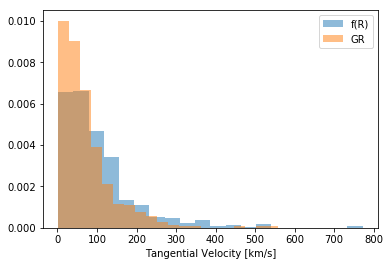

In [40]:
a = plt.hist(tangential_vel_FR, bins=20, alpha=0.5, normed=True, label='f(R)')
a = plt.hist(tangential_vel_GR, bins=20, alpha=0.5, normed=True, label='GR')
plt.legend()
plt.xlabel("Tangential Velocity [km/s]")
print(np.percentile(tangential_vel_FR, q=[34,50,66]))
print(np.percentile(tangential_vel_GR, q=[34,50,66]))
scipy.stats.ks_2samp(tangential_vel_FR,tangential_vel_GR)

0.537669064145
0.532487536171


Ks_2sampResult(statistic=0.04373332954996878, pvalue=0.68091443687329134)

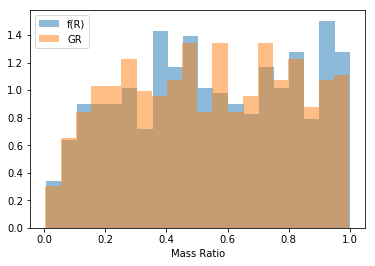

In [41]:
mass_ratio_FR = max_mass_FR = np.min([mvir_A_FR, mvir_B_FR],axis=0)/np.max([mvir_A_FR, mvir_B_FR],axis=0)
mass_ratio_GR = max_mass_GR = np.min([mvir_A_GR, mvir_B_GR],axis=0)/np.max([mvir_A_GR, mvir_B_GR],axis=0)

a = plt.hist(mass_ratio_FR, bins=20, alpha=0.5, normed=True, label='f(R)')
a = plt.hist(mass_ratio_GR, bins=20, alpha=0.5, normed=True, label='GR')
plt.legend()
plt.xlabel("Mass Ratio")
print(np.percentile(mass_ratio_FR, q=50))
print(np.percentile(mass_ratio_GR, q=50))
scipy.stats.ks_2samp(mass_ratio_FR,mass_ratio_GR)

## Distributions for the Local Group sample (constraints on the radial velocity)

In [42]:
ii_FR = (radial_vel_FR<-100.0)&(radial_vel_FR>-120)
ii_GR = (radial_vel_GR<-100.0)&(radial_vel_GR>-120)
print(np.count_nonzero(ii_FR), np.count_nonzero(ii_GR))

13 12


median separation FR 0.527171634385
median separation GR 0.413705081552


Ks_2sampResult(statistic=0.29487179487179493, pvalue=0.56879711359813356)

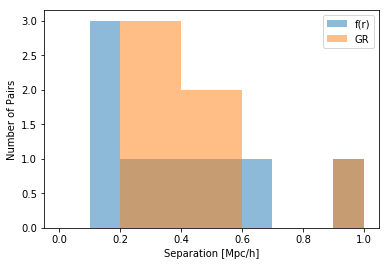

In [43]:
a = plt.hist(norm_relative_pos_FR[ii_FR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='f(r)')
a = plt.hist(norm_relative_pos_GR[ii_GR], bins=np.linspace(0.0,1.0,11), alpha=0.5, label='GR')
plt.xlabel('Separation [Mpc/h]')
plt.ylabel('Number of Pairs')
plt.legend()

print('median separation FR', np.percentile(norm_relative_pos_FR[ii_FR],q=50))
print('median separation GR', np.percentile(norm_relative_pos_GR[ii_GR],q=50))
scipy.stats.ks_2samp(norm_relative_pos_FR[ii_FR],norm_relative_pos_GR[ii_GR])

median log10 total mass FR [ 11.85793403  11.96622624  12.13520794]
median log10 total mass GR [ 11.89961492  12.16789591  12.36538801]


Ks_2sampResult(statistic=0.34615384615384615, pvalue=0.36377259007824497)

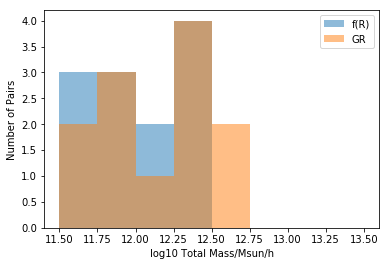

In [44]:
a = plt.hist(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='f(R)')
a = plt.hist(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]), bins=np.linspace(11.5,13.5,9), alpha=0.5, label='GR')
plt.xlabel('log10 Total Mass/Msun/h')
plt.ylabel('Number of Pairs')
plt.legend()
print('median log10 total mass FR', np.percentile(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]),q=[34,50,66]))
print('median log10 total mass GR', np.percentile(np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]),q=[34,50,66]))
scipy.stats.ks_2samp(np.log10(mvir_A_FR[ii_FR]+mvir_B_FR[ii_FR]), np.log10(mvir_A_GR[ii_GR]+mvir_B_GR[ii_GR]))

median vtan FR [ 149.34860471  166.1220902   184.20802788]
median vtan GR [ 149.19303672  164.5656615   180.45884031]


Ks_2sampResult(statistic=0.22435897435897434, pvalue=0.86790129440181241)

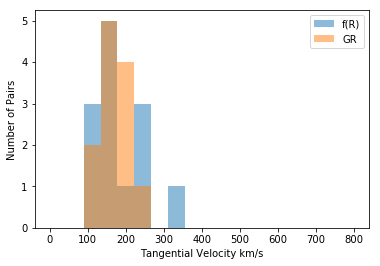

In [45]:
a = plt.hist(tangential_vel_FR[ii_FR], bins=np.linspace(0,800,19), alpha=0.5, label='f(R)')
a = plt.hist(tangential_vel_GR[ii_GR], bins=np.linspace(0,800,19), alpha=0.5, label='GR')
plt.xlabel('Tangential Velocity km/s')
plt.ylabel('Number of Pairs')
plt.legend()
print('median vtan FR', np.percentile(tangential_vel_FR[ii_FR], q=[34,50,66]))
print('median vtan GR', np.percentile(tangential_vel_GR[ii_GR], q=[34,50,66]))
scipy.stats.ks_2samp(tangential_vel_FR[ii_FR],tangential_vel_GR[ii_GR])

median mass ratio FR [ 0.16904098  0.25865015  0.3637939 ]
median mass ratio GR [ 0.29676746  0.35741508  0.50560067]


Ks_2sampResult(statistic=0.30128205128205132, pvalue=0.54085416614625137)

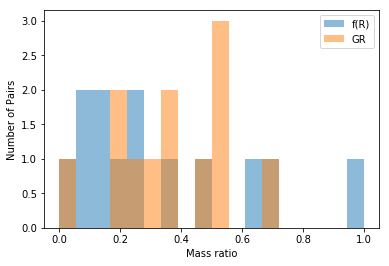

In [46]:
a = plt.hist(mass_ratio_FR[ii_FR], bins=np.linspace(0,1.0,19), alpha=0.5, label='f(R)')
a = plt.hist(mass_ratio_GR[ii_GR], bins=np.linspace(0,1.0,19), alpha=0.5, label='GR')
plt.xlabel('Mass ratio')
plt.ylabel('Number of Pairs')
plt.legend()
print('median mass ratio FR', np.percentile(mass_ratio_FR[ii_FR], q=[34,50,66]))
print('median mass ratio GR', np.percentile(mass_ratio_GR[ii_GR], q=[34,50,66]))
scipy.stats.ks_2samp(mass_ratio_FR[ii_FR],mass_ratio_GR[ii_GR])

## Conclusions

* Isolated Pairs can be differentiated by its tangential relative velocity. It is higher in $f(R)$ ($73$ km/s) than in $GR$ ($52$ km/s).
* However, Local Group Pairs have the same kinematics (i.e. separation, total mass and tangential velocity) in $f(R)$ and $GR$ simulations. 
* Our predicted tangential velocity for Local Group Pairs ($165\pm 15$ km/s) matches perfectly Salomon et al. 2016 http://adsabs.harvard.edu/abs/2016MNRAS.456.4432S, and contradicts Sohn et al. 2012 http://adsabs.harvard.edu/abs/2012ApJ...753....7S.
* We don't agree with previous numerical studies (http://adsabs.harvard.edu/abs/2017MNRAS.466.4813C) that claim:
    - A difference in radial/tangential velocities for Local Group Pairs.  
    - A number density of Local Group pairs $~30$ times lower than the one we find.  
**The biggest difference is that their simulation has a mass resolution 64 times lower. **

# Samples under observational conditions

In [47]:
relative_pos_FR = pos_B_FR - pos_A_FR
relative_vel_FR = vel_B_FR - vel_A_FR

relative_pos_GR = pos_B_GR - pos_A_GR
relative_vel_GR = vel_B_GR - vel_A_GR

sky_distance_FR = np.sqrt((relative_pos_FR[:,0]**2 + relative_pos_FR[:,1]**2))
los_delta_vel_FR = np.fabs(relative_vel_FR[:,2] + 100*relative_pos_FR[:,2])

#x and y are the directions on the sky
#z is the direction along the line of sight
sky_distance_GR = np.sqrt((relative_pos_GR[:,0]**2 + relative_pos_GR[:,1]**2))
los_delta_vel_GR = np.fabs(relative_vel_GR[:,2] + 100*relative_pos_GR[:,2])

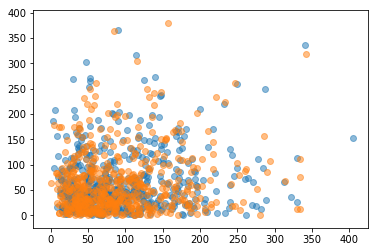

In [48]:
plt.scatter(sky_distance_FR*100, los_delta_vel_FR, alpha=0.5)
plt.scatter(sky_distance_GR*100, los_delta_vel_GR, alpha=0.5)

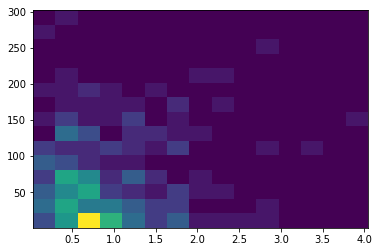

In [49]:
a = plt.hist2d(sky_distance_FR[mass_ratio_FR<0.5], los_delta_vel_FR[mass_ratio_FR<0.5], bins=15)

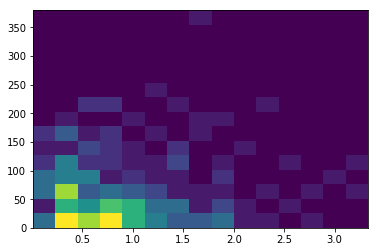

In [50]:
a = plt.hist2d(sky_distance_GR[mass_ratio_GR<0.5], los_delta_vel_GR[mass_ratio_GR<0.5],bins=15)

In [51]:
FR_select = (sky_distance_FR<0.5)
GR_select = (sky_distance_GR<0.5)
print(scipy.stats.ks_2samp(los_delta_vel_FR[FR_select],los_delta_vel_GR[GR_select]))

FR_select = (mass_ratio_FR<0.99)&(los_delta_vel_FR<100)
GR_select = (mass_ratio_GR<0.99)&(los_delta_vel_GR<100)
print(scipy.stats.ks_2samp(sky_distance_FR[FR_select],sky_distance_GR[GR_select]))

Ks_2sampResult(statistic=0.11037021000216496, pvalue=0.29589211348693267)
Ks_2sampResult(statistic=0.04342047477058919, pvalue=0.81966089269709674)


Ks_2sampResult(statistic=0.070079170079170083, pvalue=0.37741869446394932)

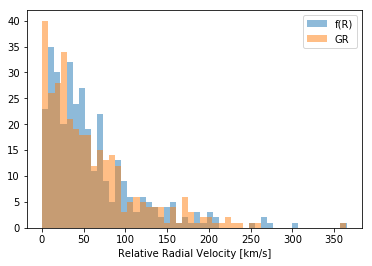

In [52]:
a = plt.hist(los_delta_vel_FR[sky_distance_FR<1.0], bins=50, alpha=0.5, label='f(R)')
a = plt.hist(los_delta_vel_GR[sky_distance_GR<1.0], bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Relative Radial Velocity [km/s]")
scipy.stats.ks_2samp(los_delta_vel_FR[sky_distance_FR<1.0],los_delta_vel_GR[sky_distance_GR<1.0])

Ks_2sampResult(statistic=0.033057147721468699, pvalue=0.92985853657267992)

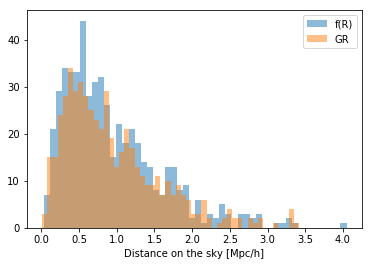

In [54]:
a = plt.hist(sky_distance_FR, bins=50, alpha=0.5, label='f(R)')
a = plt.hist(sky_distance_GR, bins=50, alpha=0.5, label='GR')
plt.legend()
plt.xlabel("Distance on the sky [Mpc/h]")
scipy.stats.ks_2samp(sky_distance_FR,sky_distance_GR)

# Machine learning

Try to use random forets, support vector machine and gaussian process to distinguish between the two data sets

In [55]:
FR_data = np.array([sky_distance_FR/sky_distance_FR.std(), los_delta_vel_FR/los_delta_vel_FR.std(), mass_ratio_FR])
FR_data = FR_data.T
GR_data = np.array([sky_distance_GR/sky_distance_GR.std(), los_delta_vel_GR/los_delta_vel_GR.std(), mass_ratio_GR])
GR_data = GR_data.T

n_FR = len(FR_data)
n_GR = len(GR_data)
print(np.shape(FR_data[:,0]))
Y = np.zeros(n_FR+n_GR)
Y[0:n_FR] = 1.0
X = np.concatenate((FR_data, GR_data), axis=0)
print(np.shape(X))


(536,)
(1062, 3)


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO

In [57]:
for i in range(10):
    clf = RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)

124 266 0.46616541353383456
135 266 0.5075187969924813
125 266 0.4699248120300752
128 266 0.48120300751879697
123 266 0.462406015037594
119 266 0.4473684210526316
137 266 0.5150375939849624
131 266 0.4924812030075188
118 266 0.44360902255639095
110 266 0.41353383458646614


In [58]:
from sklearn.svm import SVC

In [59]:
for i in range(10):
    clf = SVC()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train) 
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)

124 266 0.46616541353383456
124 266 0.46616541353383456
118 266 0.44360902255639095
123 266 0.462406015037594
112 266 0.42105263157894735
130 266 0.48872180451127817
130 266 0.48872180451127817
120 266 0.45112781954887216
127 266 0.4774436090225564
122 266 0.45864661654135336


In [60]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [61]:
for i in range(10):
    clf =  GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    clf.fit(X_train, Y_train) 
    Y_predict = clf.predict(X_test)
    n_good = np.count_nonzero(Y_predict==Y_test)
    n_all = len(Y_test)
    print(n_good, n_all, n_good/n_all)


127 266 0.4774436090225564
131 266 0.4924812030075188
126 266 0.47368421052631576
133 266 0.5
137 266 0.5150375939849624
134 266 0.5037593984962406
124 266 0.46616541353383456
130 266 0.48872180451127817
126 266 0.47368421052631576
137 266 0.5150375939849624
